# Assignment 4

Name        : Chia Sin Liew   
Last edited : May 5th, 2022 

The goal of this assignment is to solve regression and classification problems using following models.

- **Part A**: Extensive Study of the MLP Model
- **Part B**: Design an MLP for Optimal Performance

## Part A: Design an MLP for Optimal Performance

You will design an MLP for the optimal performance on the following dataset.

### **Dataset**:
The CIFAR-10 dataset (Canadian Institute For Advanced Research) contains 60,000 32 x 32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. You may directly load this dataset using the Keras API: https://keras.io/api/datasets/cifar10/

The train set contains 50,000 images, and the test set contains 10,000 images.

### **Preprocessing**:

You will need to perform some pre-processing steps. First step is to reshape the data. The dimension of the training set is 50000 x 32 x 32 x 3 and test set is 10000 x 32 x 32 x 3. Before you use this data for the MLP model, you need to flatten each sample (i.e., 32 x 32 x 3 = 3072) such the dimension of training and test set becomes:
- 50000 x 3072
- 10000 x 3072

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

In [2]:
# first load data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
print(X_train_full.shape)
print(y_train_full.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [3]:
# Reshape data 
X_train_full = X_train_full.reshape(50000, 3072)
X_test = X_test.reshape(10000, 3072)

# Convert 1D vector into 1D array
y_train_full = y_train_full.ravel()
y_test = y_test.ravel()


print(X_train_full.shape)
print(y_train_full.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [4]:
# Create a validation subset as well as scale (max-min scaling) the data
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

print("No. of Training Samples: ", X_train.shape)
print("No. of Training Labels: ", y_train.shape)

print("\nNo. of Validation Samples: ", X_valid.shape)
print("No. of Validation Labels: ", y_valid.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nX type: ", X_train.dtype)
print("y type: ", y_train.dtype)

No. of Training Samples:  (45000, 3072)
No. of Training Labels:  (45000,)

No. of Validation Samples:  (5000, 3072)
No. of Validation Labels:  (5000,)

No. of Testing Samples:  (10000, 3072)
No. of Testing Labels:  (10000,)

X type:  float64
y type:  uint8


### Experiments
Design an MLP classifier and perform multi-class classification. You must have an optimal design by finding optimal values for the following attributes: 
- hidden layers 
- neurons in each hidden layer
- initializer for the weights 
- activation function for the hidden layers 
- regularization technique (weight decay, dropout, early stopping)
- size of mini batch
- learning rate. 

You may optimize additional attributes.


#### Experiment 1

##### Build the MLP Model

In [5]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[3072]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))

model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
_________________________________________________________________
CPU times: user 153 ms, sys: 26.5 ms, total: 179 ms
Wall time: 145 ms


2022-05-05 08:29:17.473528: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Train the MLP Model

In [6]:
%%time

'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

2022-05-05 08:29:17.987378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
704/704 [==============================] - 13s 19ms/step - loss: 2.0201 - accuracy: 0.2615 - val_loss: 1.9497 - val_accuracy: 0.2880
Epoch 2/50
704/704 [==============================] - 12s 17ms/step - loss: 1.7350 - accuracy: 0.3806 - val_loss: 2.4600 - val_accuracy: 0.2616
Epoch 3/50
704/704 [==============================] - 10s 15ms/step - loss: 1.6597 - accuracy: 0.4115 - val_loss: 2.6547 - val_accuracy: 0.2188
Epoch 4/50
704/704 [==============================] - 12s 16ms/step - loss: 1.5782 - accuracy: 0.4356 - val_loss: 2.8448 - val_accuracy: 0.2180
Epoch 5/50
704/704 [==============================] - 13s 19ms/step - loss: 1.5467 - accuracy: 0.4500 - val_loss: 1.9816 - val_accuracy: 0.3292
Epoch 6/50
704/704 [==============================] - 11s 15ms/step - loss: 1.4825 - accuracy: 0.4683 - val_loss: 1.9295 - val_accuracy: 0.3516
Epoch 7/50
704/704 [==============================] - 9s 13ms/step - loss: 1.4459 - accuracy: 0.4835 - val_loss: 2.1608 - val_accuracy: 

##### History object

In [7]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 704}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##### Model evaluation

In [8]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  23

Test Data: Loss & Accuracy:  [1.9210180044174194, 0.3991999924182892]

Train Accuracy:  0.47257777777777776

Test Accuracy:  0.3992

Test Confusion Matrix:
[[ 90 104  54  34 114 231   6  49 266  52]
 [  9 666  23  19  30  53   6  21  96  77]
 [  8  20 310  70 196 302  17  35  31  11]
 [  0  36  71 239  81 484  21  27  29  12]
 [  3  11 136  31 431 277  30  53  24   4]
 [  1  14  90 120  80 623  22  28  16   6]
 [  1  27 149  90 158 293 259   7  11   5]
 [  9  30  84  48 124 245   5 396  34  25]
 [ 10 155  18  20  51  86   1  14 615  30]
 [  4 292  25  59  41  65   9  37 105 363]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.09      0.16      1000
           1       0.49      0.67      0.57      1000
           2       0.32      0.31      0.32      1000
           3       0.33      0.24      0.28      1000
           4       0.33      0.43      0.37      1000
           5       0.23      0.62      0.34      10

##### Plot Learning Curves

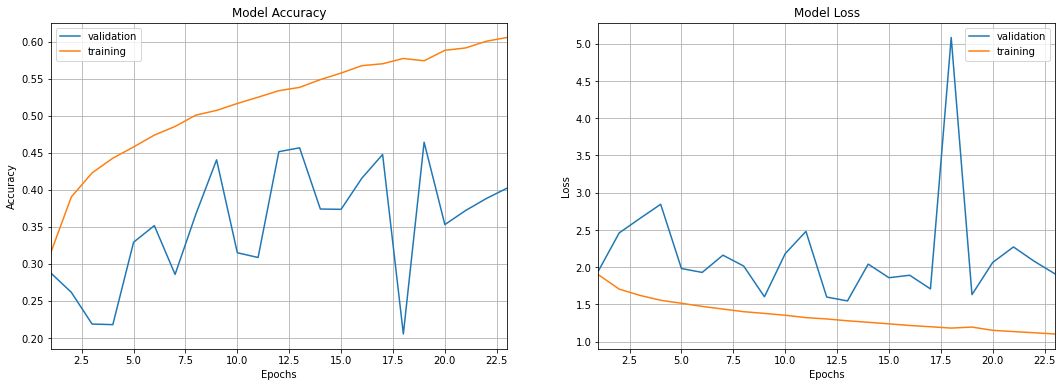

In [9]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show() 

#### Experiment 2

##### Build the MLP Model

In [10]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[3072]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))

model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
___________________________________

##### Train the MLP Model

In [11]:
%%time

'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
704/704 [==============================] - 11s 15ms/step - loss: 2.0391 - accuracy: 0.2547 - val_loss: 2.0586 - val_accuracy: 0.2632
Epoch 2/50
704/704 [==============================] - 10s 15ms/step - loss: 1.7684 - accuracy: 0.3684 - val_loss: 2.2898 - val_accuracy: 0.2694
Epoch 3/50
704/704 [==============================] - 9s 13ms/step - loss: 1.6937 - accuracy: 0.3956 - val_loss: 2.5126 - val_accuracy: 0.2094
Epoch 4/50
704/704 [==============================] - 10s 14ms/step - loss: 1.6264 - accuracy: 0.4185 - val_loss: 3.0718 - val_accuracy: 0.2184
Epoch 5/50
704/704 [==============================] - 12s 17ms/step - loss: 1.6029 - accuracy: 0.4244 - val_loss: 2.5435 - val_accuracy: 0.2258
Epoch 6/50
704/704 [==============================] - 11s 15ms/step - loss: 1.5724 - accuracy: 0.4374 - val_loss: 1.9040 - val_accuracy: 0.3378
Epoch 7/50
704/704 [==============================] - 9s 13ms/step - loss: 1.5086 - accuracy: 0.4586 - val_loss: 1.7450 - val_accuracy: 0

##### History object

In [12]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 704}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##### Model evaluation

In [13]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  22

Test Data: Loss & Accuracy:  [1.6492360830307007, 0.4189000129699707]

Train Accuracy:  0.4676888888888889

Test Accuracy:  0.4189

Test Confusion Matrix:
[[851   6   8   9  15   0  36   5  26  44]
 [183 521  22  10  13   6  36   9  15 185]
 [322  11 136  37 173  27 244  23  10  17]
 [196   9  47 189  53  61 366  19  13  47]
 [194   4  37  29 462  14 215  20   7  18]
 [174   5  57 155  68 185 295  21  16  24]
 [ 97  11  18  24 109   7 708   4   6  16]
 [266  11  24  54 138  37 134 282   2  52]
 [455  55   6   7   7   7  45   1 305 112]
 [201 132  10   9  16   8  51   6  17 550]]

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.85      0.43      1000
           1       0.68      0.52      0.59      1000
           2       0.37      0.14      0.20      1000
           3       0.36      0.19      0.25      1000
           4       0.44      0.46      0.45      1000
           5       0.53      0.18      0.27      100

##### Plot Learning Curves

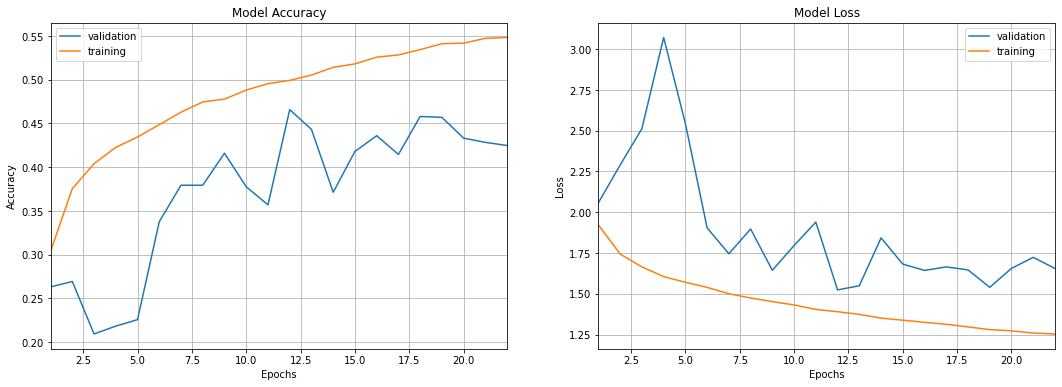

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show() 

#### Experiment 3

##### Build the MLP Model

In [15]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'sigmoid'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[3072]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))

model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
_________________________________________________________________
CPU times: user 56.8 ms, sys: 40.8 ms, total: 97.6 ms
Wall time: 67.6 ms


##### Train the MLP Model

In [16]:
%%time

'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
704/704 [==============================] - 11s 15ms/step - loss: 2.2629 - accuracy: 0.1390 - val_loss: 2.0643 - val_accuracy: 0.1928
Epoch 2/50
704/704 [==============================] - 11s 15ms/step - loss: 1.9754 - accuracy: 0.2763 - val_loss: 2.0425 - val_accuracy: 0.2308
Epoch 3/50
704/704 [==============================] - 10s 15ms/step - loss: 1.8876 - accuracy: 0.3203 - val_loss: 2.0093 - val_accuracy: 0.2668
Epoch 4/50
704/704 [==============================] - 11s 15ms/step - loss: 1.8336 - accuracy: 0.3413 - val_loss: 2.4575 - val_accuracy: 0.1908
Epoch 5/50
704/704 [==============================] - 11s 16ms/step - loss: 1.7860 - accuracy: 0.3570 - val_loss: 1.9042 - val_accuracy: 0.3040
Epoch 6/50
704/704 [==============================] - 10s 15ms/step - loss: 1.7357 - accuracy: 0.3732 - val_loss: 1.7329 - val_accuracy: 0.3672
Epoch 7/50
704/704 [==============================] - 11s 16ms/step - loss: 1.7048 - accuracy: 0.3878 - val_loss: 1.9365 - val_accuracy:

##### History object

In [17]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 704}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##### Model evaluation

In [18]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  37

Test Data: Loss & Accuracy:  [1.4808027744293213, 0.48170000314712524]

Train Accuracy:  0.532

Test Accuracy:  0.4817

Test Confusion Matrix:
[[495  74  64 120   8   9  67   6  96  61]
 [ 12 735   7  63   1   8  29   8  19 118]
 [ 51  26 278 267  32  57 245  17   7  20]
 [  8  25  30 626   3  84 176   4  12  32]
 [ 39  18 128 213 179  39 321  27  17  19]
 [  7  15  34 462  17 287 131  14  14  19]
 [  4  18  26 143  15  16 758   2   4  14]
 [ 28  32  50 225  37  77 100 369   9  73]
 [ 79 132   8 105   6   8  21   6 559  76]
 [ 31 254   4  96   4  12  37   8  23 531]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.49      0.56      1000
           1       0.55      0.73      0.63      1000
           2       0.44      0.28      0.34      1000
           3       0.27      0.63      0.38      1000
           4       0.59      0.18      0.27      1000
           5       0.48      0.29      0.36      1000
          

##### Plot Learning Curves

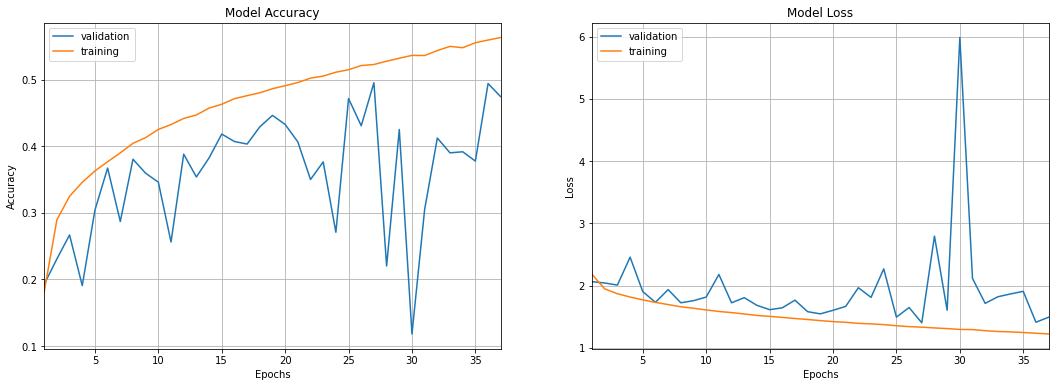

In [19]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show() 

#### Experiment 4

##### Build the MLP Model

In [20]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'sigmoid'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[3072]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))

model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
___________________________________

##### Train the MLP Model

In [21]:
%%time

'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
704/704 [==============================] - 12s 17ms/step - loss: 2.2717 - accuracy: 0.1317 - val_loss: 2.0583 - val_accuracy: 0.1998
Epoch 2/50
704/704 [==============================] - 11s 16ms/step - loss: 2.0031 - accuracy: 0.2613 - val_loss: 2.0001 - val_accuracy: 0.2422
Epoch 3/50
704/704 [==============================] - 10s 15ms/step - loss: 1.9161 - accuracy: 0.3048 - val_loss: 1.8981 - val_accuracy: 0.2978
Epoch 4/50
704/704 [==============================] - 11s 15ms/step - loss: 1.8715 - accuracy: 0.3233 - val_loss: 2.1813 - val_accuracy: 0.2482
Epoch 5/50
704/704 [==============================] - 11s 16ms/step - loss: 1.8273 - accuracy: 0.3411 - val_loss: 1.8624 - val_accuracy: 0.3124
Epoch 6/50
704/704 [==============================] - 11s 16ms/step - loss: 1.7866 - accuracy: 0.3516 - val_loss: 1.7364 - val_accuracy: 0.3682
Epoch 7/50
704/704 [==============================] - 11s 16ms/step - loss: 1.7586 - accuracy: 0.3659 - val_loss: 1.7848 - val_accuracy:

##### History object

In [22]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 704}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##### Model evaluation

In [23]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  50

Test Data: Loss & Accuracy:  [1.5200598239898682, 0.4636000096797943]

Train Accuracy:  0.5076

Test Accuracy:  0.4636

Test Confusion Matrix:
[[276 294 134  23  45   9  18   9  87 105]
 [  0 872  10  12   8   4   7   5   5  77]
 [ 34  88 367 101 169  47  93  40  15  46]
 [  4 124  82 388  72 109  88  26  17  90]
 [ 16  97 127  67 467  25 101  51  11  38]
 [  4  70  96 267  78 304  65  40  19  57]
 [  2 106  50  94 120  25 544  12  10  37]
 [ 10 103  50  75  82  48  28 457   5 142]
 [ 20 336  16  18  29  14   1   5 481  80]
 [  2 452   4  21   4   6  12   9  10 480]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.28      0.40      1000
           1       0.34      0.87      0.49      1000
           2       0.39      0.37      0.38      1000
           3       0.36      0.39      0.38      1000
           4       0.43      0.47      0.45      1000
           5       0.51      0.30      0.38      1000
          

##### Plot Learning Curves

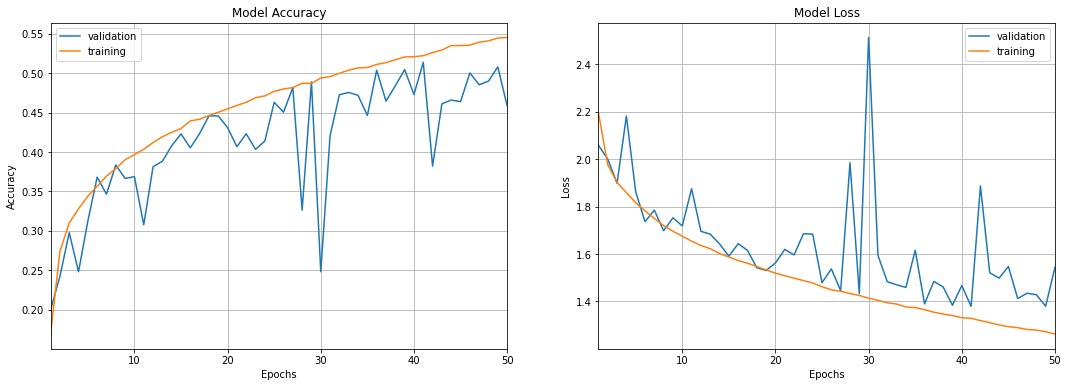

In [24]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show() 

#### Experiment 5

##### Build the MLP Model

In [36]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[3072]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))

model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
_________________________________________________________________
CPU times: user 62.7 ms, sys: 42.4 ms, total: 105 ms
Wall time: 70.9 ms


##### Train the MLP Model

In [37]:
%%time

'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 1000


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
45/45 [==============================] - 7s 148ms/step - loss: 2.2248 - accuracy: 0.1901 - val_loss: 2.0145 - val_accuracy: 0.2914
Epoch 2/50
45/45 [==============================] - 6s 128ms/step - loss: 2.0242 - accuracy: 0.2810 - val_loss: 2.0467 - val_accuracy: 0.2616
Epoch 3/50
45/45 [==============================] - 6s 126ms/step - loss: 1.9623 - accuracy: 0.3073 - val_loss: 1.8592 - val_accuracy: 0.3448
Epoch 4/50
45/45 [==============================] - 6s 136ms/step - loss: 1.8796 - accuracy: 0.3356 - val_loss: 1.8900 - val_accuracy: 0.3272
Epoch 5/50
45/45 [==============================] - 5s 113ms/step - loss: 1.8539 - accuracy: 0.3435 - val_loss: 1.7899 - val_accuracy: 0.3646
Epoch 6/50
45/45 [==============================] - 5s 113ms/step - loss: 1.8047 - accuracy: 0.3580 - val_loss: 1.8026 - val_accuracy: 0.3406
Epoch 7/50
45/45 [==============================] - 5s 112ms/step - loss: 1.7830 - accuracy: 0.3648 - val_loss: 1.7498 - val_accuracy: 0.3734
Epoch 

##### History object

In [38]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 45}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##### Model evaluation

In [39]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  50

Test Data: Loss & Accuracy:  [1.4528534412384033, 0.48089998960494995]

Train Accuracy:  0.5259333333333334

Test Accuracy:  0.4809

Test Confusion Matrix:
[[679  28  55  13  30  17   6  65  78  29]
 [ 76 608   7  10  10  29   7  64  48 141]
 [107  22 351  49 158  84  43 155  17  14]
 [ 60  15  89 264  64 222  43 163  29  51]
 [ 83  12 137  40 401  54  45 198  22   8]
 [ 42  14  89 136  67 380  22 195  33  22]
 [ 25  21 104  77 195  93 317 137  17  14]
 [ 56  13  36  35  51  43   4 719   8  35]
 [223  69  15  12  16  24   1  38 554  48]
 [ 82 173  11  17   7  24  13  91  46 536]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.68      0.56      1000
           1       0.62      0.61      0.62      1000
           2       0.39      0.35      0.37      1000
           3       0.40      0.26      0.32      1000
           4       0.40      0.40      0.40      1000
           5       0.39      0.38      0.39      10

##### Plot Learning Curves

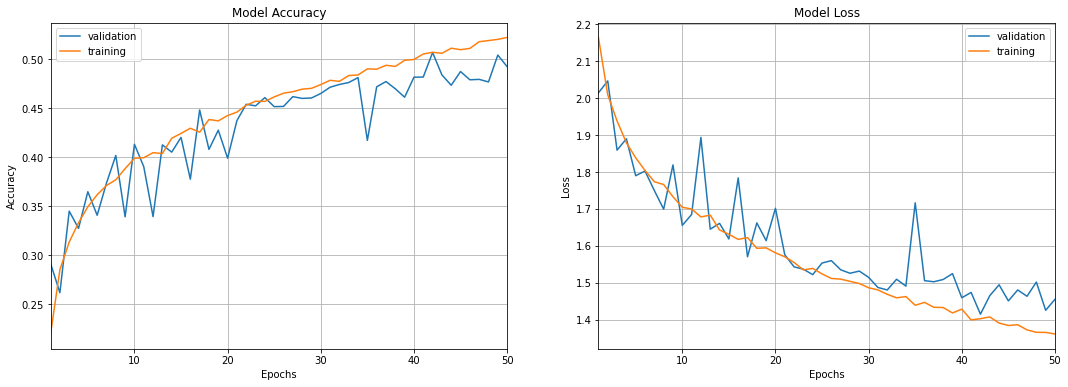

In [40]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show() 

#### Experiment 6

##### Build the MLP Model

In [75]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[3072]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))

model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
_________________________________________________________________
CPU times: user 61 ms, sys: 9.17 ms, total: 70.2 ms
Wall time: 43.7 ms


##### Train the MLP Model

In [76]:
%%time

'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 1000


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
45/45 [==============================] - 7s 155ms/step - loss: 2.2324 - accuracy: 0.1721 - val_loss: 1.9527 - val_accuracy: 0.3272
Epoch 2/50
45/45 [==============================] - 6s 121ms/step - loss: 2.0782 - accuracy: 0.2653 - val_loss: 2.0949 - val_accuracy: 0.2100
Epoch 3/50
45/45 [==============================] - 6s 127ms/step - loss: 1.9796 - accuracy: 0.2956 - val_loss: 1.8716 - val_accuracy: 0.3346
Epoch 4/50
45/45 [==============================] - 6s 123ms/step - loss: 1.8900 - accuracy: 0.3251 - val_loss: 1.8361 - val_accuracy: 0.3438
Epoch 5/50
45/45 [==============================] - 5s 120ms/step - loss: 1.8560 - accuracy: 0.3365 - val_loss: 1.9079 - val_accuracy: 0.3062
Epoch 6/50
45/45 [==============================] - 6s 137ms/step - loss: 1.8226 - accuracy: 0.3486 - val_loss: 1.7201 - val_accuracy: 0.3838
Epoch 7/50
45/45 [==============================] - 6s 122ms/step - loss: 1.7954 - accuracy: 0.3583 - val_loss: 1.7030 - val_accuracy: 0.4010
Epoch 

##### History object

In [77]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 45}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##### Model evaluation

In [78]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  50

Test Data: Loss & Accuracy:  [1.3942852020263672, 0.5065000057220459]

Train Accuracy:  0.5677777777777778

Test Accuracy:  0.5065

Test Confusion Matrix:
[[632  21  96  31  41  12  12  32  90  33]
 [ 65 611  26  40  13  17  11  33  58 126]
 [ 77  14 418 137 177  33  50  68   9  17]
 [ 34  15 112 475  76 119  72  54  13  30]
 [ 58   6 151  91 490  36  60  82  18   8]
 [ 27  13 124 318  81 293  39  75  15  15]
 [ 17  11  95 152 168  36 457  33  14  17]
 [ 54  11  76  86 102  46  16 569   6  34]
 [177  54  27  42  27  14   3  24 589  43]
 [ 75 163  17  56  19  20  22  51  46 531]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.63      0.57      1000
           1       0.66      0.61      0.64      1000
           2       0.37      0.42      0.39      1000
           3       0.33      0.47      0.39      1000
           4       0.41      0.49      0.45      1000
           5       0.47      0.29      0.36      100

##### Plot Learning Curves

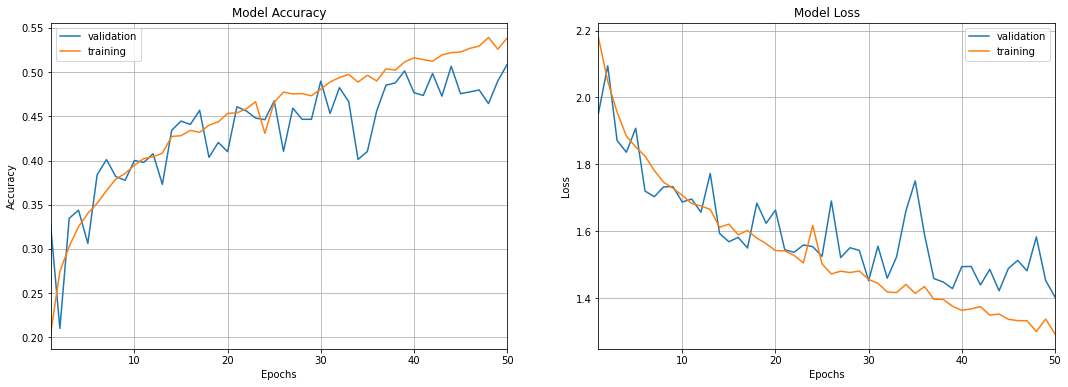

In [79]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show() 

#### Experiment 7

##### Build the MLP Model

In [80]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[3072]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
# model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))

model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
_________________________________________________________________
CPU times: user 52 ms, sys: 16.3 ms, total: 68.3 ms
Wall time: 34.9 ms


##### Train the MLP Model

In [81]:
%%time

'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 50
size_of_mini_batch = 500


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/50
90/90 [==============================] - 7s 71ms/step - loss: 2.1787 - accuracy: 0.2091 - val_loss: 1.9241 - val_accuracy: 0.3200
Epoch 2/50
90/90 [==============================] - 6s 71ms/step - loss: 1.9415 - accuracy: 0.3099 - val_loss: 1.8152 - val_accuracy: 0.3454
Epoch 3/50
90/90 [==============================] - 6s 65ms/step - loss: 1.8495 - accuracy: 0.3465 - val_loss: 1.7417 - val_accuracy: 0.3818
Epoch 4/50
90/90 [==============================] - 6s 64ms/step - loss: 1.7895 - accuracy: 0.3649 - val_loss: 1.7593 - val_accuracy: 0.3694
Epoch 5/50
90/90 [==============================] - 6s 64ms/step - loss: 1.7401 - accuracy: 0.3816 - val_loss: 1.7491 - val_accuracy: 0.3694
Epoch 6/50
90/90 [==============================] - 6s 62ms/step - loss: 1.7119 - accuracy: 0.3958 - val_loss: 1.6443 - val_accuracy: 0.4110
Epoch 7/50
90/90 [==============================] - 6s 64ms/step - loss: 1.6752 - accuracy: 0.4060 - val_loss: 1.6394 - val_accuracy: 0.4168
Epoch 8/50
90

##### History object

In [82]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 50, 'steps': 90}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##### Model evaluation

In [83]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  50

Test Data: Loss & Accuracy:  [1.4207123517990112, 0.4999000132083893]

Train Accuracy:  0.5830444444444445

Test Accuracy:  0.4999

Test Confusion Matrix:
[[570  21 111  34  16  13  30   7 124  74]
 [ 28 538  30  46   6  17  21   8  65 241]
 [ 57  10 546 131  57  58  97   7  14  23]
 [ 24   9 138 451  18 154 128  11  21  46]
 [ 47   6 291 111 273  49 153  23  28  19]
 [ 15   3 159 306  26 343  90  12  21  25]
 [ 10   8 129 104  35  44 636   3   8  23]
 [ 44   8 156 131  72  89  58 338  18  86]
 [106  44  38  48   5  26  14   1 637  81]
 [ 28  89  34  68   4  17  27  10  56 667]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.57      0.59      1000
           1       0.73      0.54      0.62      1000
           2       0.33      0.55      0.41      1000
           3       0.32      0.45      0.37      1000
           4       0.53      0.27      0.36      1000
           5       0.42      0.34      0.38      100

##### Plot Learning Curves

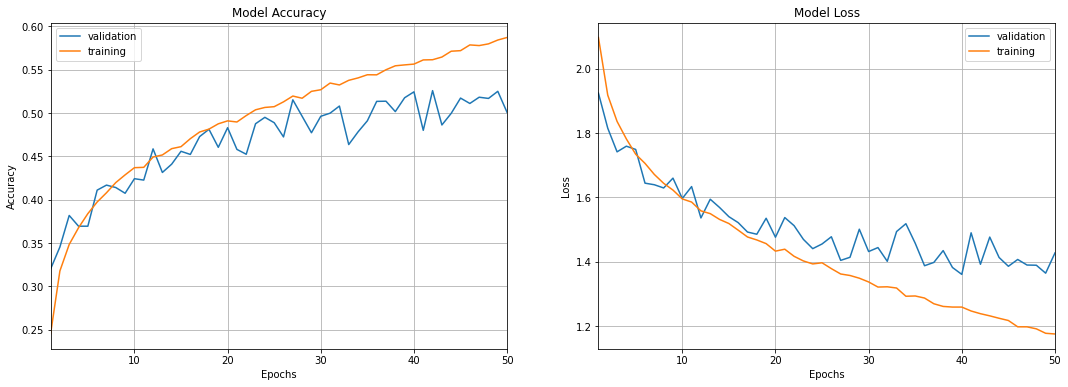

In [84]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show() 

#### Experiment 8

##### Build the MLP Model

In [106]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Set the values for weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation = 'relu'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[3072]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation, 
                             bias_initializer="zeros"))
model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation,
                            bias_initializer="zeros"))
model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer, 
                             activation="softmax"))

model.summary()

Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
___________________________________

##### Train the MLP Model

In [107]:
%%time

'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create the early stopping callback function.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=False)

'''
Set the epochs and mini batch size
'''
no_of_epochs = 100
size_of_mini_batch = 1000


'''
Train the model
'''
history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/100
45/45 [==============================] - 6s 134ms/step - loss: 2.2318 - accuracy: 0.1722 - val_loss: 2.0441 - val_accuracy: 0.2634
Epoch 2/100
45/45 [==============================] - 6s 125ms/step - loss: 2.0378 - accuracy: 0.2738 - val_loss: 1.9395 - val_accuracy: 0.3028
Epoch 3/100
45/45 [==============================] - 5s 118ms/step - loss: 1.9552 - accuracy: 0.2993 - val_loss: 1.9528 - val_accuracy: 0.3002
Epoch 4/100
45/45 [==============================] - 5s 117ms/step - loss: 1.9012 - accuracy: 0.3192 - val_loss: 1.7983 - val_accuracy: 0.3534
Epoch 5/100
45/45 [==============================] - 5s 119ms/step - loss: 1.8433 - accuracy: 0.3413 - val_loss: 1.7666 - val_accuracy: 0.3714
Epoch 6/100
45/45 [==============================] - 5s 119ms/step - loss: 1.8110 - accuracy: 0.3539 - val_loss: 1.8073 - val_accuracy: 0.3474
Epoch 7/100
45/45 [==============================] - 6s 133ms/step - loss: 1.7733 - accuracy: 0.3696 - val_loss: 1.8321 - val_accuracy: 0.3342

Epoch 58/100
45/45 [==============================] - 5s 116ms/step - loss: 1.3072 - accuracy: 0.5310 - val_loss: 1.5654 - val_accuracy: 0.4556
Epoch 59/100
45/45 [==============================] - 5s 115ms/step - loss: 1.3716 - accuracy: 0.5116 - val_loss: 1.3724 - val_accuracy: 0.5150
Epoch 60/100
45/45 [==============================] - 5s 118ms/step - loss: 1.2845 - accuracy: 0.5434 - val_loss: 1.3992 - val_accuracy: 0.5052
Epoch 61/100
45/45 [==============================] - 5s 116ms/step - loss: 1.3060 - accuracy: 0.5372 - val_loss: 1.4105 - val_accuracy: 0.5000
Epoch 62/100
45/45 [==============================] - 5s 116ms/step - loss: 1.2974 - accuracy: 0.5385 - val_loss: 1.3727 - val_accuracy: 0.5098
Epoch 63/100
45/45 [==============================] - 5s 116ms/step - loss: 1.2813 - accuracy: 0.5425 - val_loss: 1.4302 - val_accuracy: 0.5048
Epoch 64/100
45/45 [==============================] - 5s 116ms/step - loss: 1.2942 - accuracy: 0.5396 - val_loss: 1.4525 - val_accuracy:

##### History object

In [108]:
print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

Training Parameters:  {'verbose': 1, 'epochs': 100, 'steps': 45}

List of Epochs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Evaluation Metrics:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##### Model evaluation

In [109]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  90

Test Data: Loss & Accuracy:  [1.3277033567428589, 0.5307000279426575]

Train Accuracy:  0.6362444444444444

Test Accuracy:  0.5307

Test Confusion Matrix:
[[530  34  65  34  40  25  30  22 183  37]
 [ 25 676  17  34   8  27  15  19  71 108]
 [ 65  16 449 104  98  83 115  41  18  11]
 [ 15  13  84 393  42 222 156  29  23  23]
 [ 41  10 181  70 411  55 158  46  22   6]
 [ 14   6 101 219  49 457  85  34  20  15]
 [  7  17  84  77  73  49 660  10  15   8]
 [ 20   8  69  84 103 115  41 515  17  28]
 [ 76  65  16  41  19  28  15  10 692  38]
 [ 30 179  12  58  18  31  26  34  88 524]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1000
           1       0.66      0.68      0.67      1000
           2       0.42      0.45      0.43      1000
           3       0.35      0.39      0.37      1000
           4       0.48      0.41      0.44      1000
           5       0.42      0.46      0.44      100

##### Plot Learning Curves

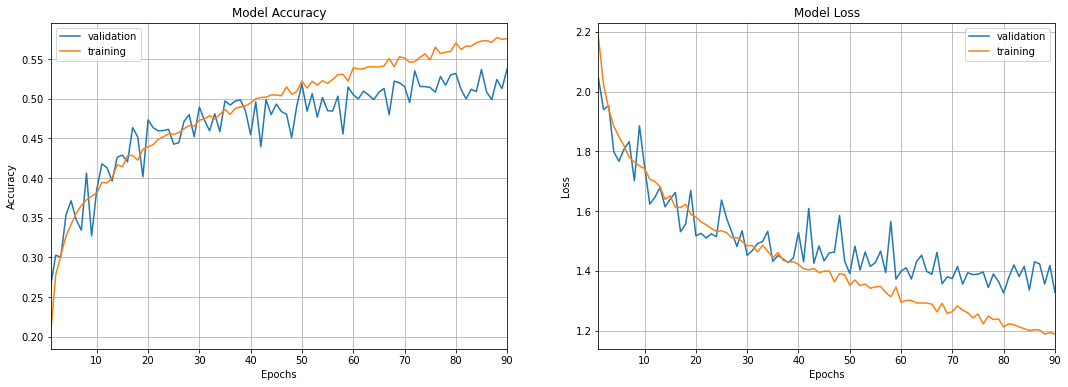

In [110]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show() 